## Pipeline de nettoyage et Exploration de données.

#### Description des données

Les données utilisées dans ce projet proviennent du **dataset BBC News**, un corpus d’articles de presse en anglais couramment utilisé pour les tâches de classification de textes.

Nous avons sélectionné **trois thématiques** :

* Technologie (Tech)
* Sport
* Politique (Politics)

Ces thématiques ont été choisies car elles sont clairement différenciables sur le plan sémantique, ce qui facilite l’apprentissage et l’évaluation des modèles de classification.

Pour chaque thématique, nous avons extrait **les 200 premiers articles** du dataset, ce qui constitue un corpus total de **600 documents**. Ce choix permet d’obtenir un dataset **équilibré** entre les classes et de garantir la **reproductibilité des expériences**, puisque la même sélection de documents est utilisée à chaque exécution du code.

Ce corpus est ensuite utilisé pour l’ensemble des étapes du projet : prétraitement linguistique, apprentissage des embeddings, classification thématique, extraction d’informations et résumé automatique.

**Source** : BBC News Dataset
[BBC Datasets](http://mlg.ucd.ie/datasets/bbc.html)


In [1]:
# Importation des packages

import os
import pandas as pd
import nltk
import spacy
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter ,defaultdict 
from tqdm import tqdm
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

C:\Users\21354\AppData\Local\Temp\ipykernel_27480\2300402237.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1. Extraction de Données:
Les données ont été extraites à partir du dataset BBC News en sélectionnant les 200 premiers documents pour chacune des thématiques suivantes : Technologie (Tech), Sport et Politique (Politics).

In [2]:
# Paths to folders
folders = {
    "politics": "Data/BBC_dataset/politics",
    "sport": "Data/BBC_dataset/sport",
    "tech": "Data/BBC_dataset/tech"
}

# Number of texts to sample per class
num_samples = 200

# List to store data
data = []

for label, folder in folders.items():
    # List all text files in the folder (sorted to have a consistent order)
    files = sorted([f for f in os.listdir(folder) if f.endswith(".txt")])
    
    # Take the first 200 files (or fewer if folder has less)
    selected_files = files[:num_samples]
    
    for file_name in selected_files:
        file_path = os.path.join(folder, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        data.append({"text": text, "label": label})


# Convert to DataFrame
df = pd.DataFrame(data)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,text,label
0,Drive to 'save' festive holidays\n\nEfforts ar...,politics
1,Brown hits back in Blair rift row\n\nGordon Br...,politics
2,Holmes is hit by hamstring injury\n\nKelly Hol...,sport
3,The future in your pocket\n\nIf you are a geek...,tech
4,O'Sullivan could run in Worlds\n\nSonia O'Sull...,sport


In [3]:
# Exemple de texte
df['text'][0]

'Drive to \'save\' festive holidays\n\nEfforts are being made to \'protect\' workers\' days off on Christmas Day and New Year\'s Day.\n\nSupport is being sought for a bill which would ensure that large retailers in Scotland remain closed on Christmas Day and 1 January. The Usdaw trade union said shop workers should be able to enjoy a break with their families. MSP Karen Whitefield wants to ensure only those whose roles are essential are at work over the festive season. In recent years, more stores have been opening on traditional holidays, with some starting their end-of-year sale on Christmas Day or New Year\'s Day. Ms Whitefield said: "I have found members of the public to be very supportive when I have been campaigning on the streets.\n\n"The early evidence shows quite clearly that the vast majority of people believe that shop workers should be given these two special days to spend with friends and family." Usdaw general secretary John Hannett added: "Christmas Day and New Year\'s D

### 2. Nettoyage de données 

In [4]:
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = text.replace('\n', ' ')  # remove line breaks
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with single space
    text = re.sub(r"[^a-zA-Z\s'. \d]",'', text)  # remove weird signs/symbols, keep letters (including accented) spaces and apostrophes
    text = text.strip()  # remove leading/trailing spaces
    return text


In [5]:
# Apply cleaning function to the text column
df["text"] = df["text"].apply(clean_text)

# Show the cleaned text of the first document
df

,text,label
0,drive to 'save' festive holidays efforts are b...,politics
1,brown hits back in blair rift row gordon brown...,politics
2,holmes is hit by hamstring injury kelly holmes...,sport
3,the future in your pocket if you are a geek or...,tech
4,o'sullivan could run in worlds sonia o'sulliva...,sport
...,...,...
595,anglers 'could face prosecution' anglers and f...,politics
596,britain boosted by holmes double athletics fan...,sport
597,citizenship event for 18s touted citizenship c...,politics
598,muslims discuss election concerns issues that ...,politics


In [6]:
# Label Encoding:
label_encoder = LabelEncoder()

df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Create a mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

df.drop('label', axis=1, inplace=True)



{'politics': 0, 'sport': 1, 'tech': 2}


### 3. Traitement linguistique : tokenisation, lemmatisation et stop words

- Pour le prétraitement linguistique, nous utilisons le modèle en_core_web_sm de SpaCy, adapté aux textes en anglais.
- Les stop words sont ceux fournis et recommandés par la source du dataset, afin de rester cohérents avec les spécificités du corpus.
- Après la tokenisation, une lemmatisation est appliquée pour ramener chaque mot à sa forme canonique et réduire la variabilité lexicale du texte.

In [7]:
# Model NLP pour la Tokenisation , lemmatisation et stop words
nlp_eng = spacy.load("en_core_web_sm")


In [8]:
# Les stop words : extrait du site BBC
CUSTOM_STOPWORDS = {
    "a","about","above","according","across","actually","adj","after","afterwards",
    "again","all","almost","along","already","also","although","always","among",
    "amongst","an","am","and","another","any","anyhow","anyone","anything","anywhere",
    "are","aren","aren't","around","as","at","be","became","because","become",
    "becomes","been","beforehand","begin","being","below","beside","besides",
    "between","both","but","by","can","cannot","can't","caption","co","come",
    "could","couldn","couldn't","did","didn","didn't","do","does","doesn","doesn't",
    "don","don't","down","during","each","early","eg","either","else","elsewhere",
    "end","ending","enough","etc","even","ever","every","everywhere","except","few",
    "for","found","from","further","had","has","hasn","hasn't","have","haven","haven't",
    "he","hence","her","here","hereafter","hereby","herein","hereupon","hers","him",
    "his","how","however","ie","i.e.","if","in","inc","inc.","indeed","instead",
    "into","is","isn","isn't","it","its","itself","last","late","later","less","let",
    "like","likely","ll","ltd","made","make","makes","many","may","maybe","me",
    "meantime","meanwhile","might","miss","more","most","mostly","mr","mrs","much",
    "must","my","myself","namely","near","neither","never","nevertheless","new","next",
    "no","nobody","non","none","nonetheless","noone","nor","not","now","null","of",
    "off","often","on","once","only","onto","or","other","others","otherwise","our",
    "ours","ourselves","out","over","own","per","perhaps","rather","re","said","same",
    "say","seem","seemed","seeming","seems","several","she","should","shouldn",
    "shouldn't","since","so","some","still","stop","such","taking","ten","than","that",
    "the","their","them","themselves","then","thence","there","thereafter","thereby",
    "therefore","therein","thereupon","these","they","this","those","though","thousand",
    "through","throughout","thru","thus","to","together","too","toward","towards",
    "under","unless","unlike","unlikely","until","up","upon","us","use","used","using",
    "ve","very","via","was","wasn","we","well","were","weren","weren't","what",
    "whatever","when","whence","whenever","where","whereafter","whereas","whereby",
    "wherein","whereupon","wherever","whether","which","while","whither","who",
    "whoever","whole","whom","whomever","whose","why","will","with","within","without",
    "won","would","wouldn","wouldn't","yes","yet","you","your","yours","yourself",
    "yourselves", "i", "m"
}


In [9]:
# Tokenisation, lemmatisation et suppression des stop words
def preprocess_text(text, nlp = nlp_eng):
    doc = nlp(text)

    tokens = [
        token.lemma_.lower()
        for token in doc
        if (token.is_alpha or token.like_num)  # keep words AND numbers
        and token.lemma_.lower() not in CUSTOM_STOPWORDS
    ]
    
    return " ".join(tokens)


In [10]:
# Apply preprocessing to the text column
df["tokens"] = df["text"].apply(preprocess_text)


In [11]:
df.head()

,text,label_encoded,tokens
0,drive to 'save' festive holidays efforts are b...,0,drive save festive holiday effort protect work...
1,brown hits back in blair rift row gordon brown...,0,brown hit back blair rift row gordon brown cri...
2,holmes is hit by hamstring injury kelly holmes...,1,holmes hit hamstring injury kelly holmes force...
3,the future in your pocket if you are a geek or...,2,future pocket geek gadget fan 12 month look go...
4,o'sullivan could run in worlds sonia o'sulliva...,1,run world sonia indicate participate month wor...


### 4. Vocabulaires

- Pour cette section, nous avons construit un vocabulaire spécifique à chaque thématique.
- Pour chaque catégorie (Sport, Tech, Politique), tous les tokens des documents correspondants sont regroupés et leur fréquence d’apparition est calculée.
- Cela permet d’identifier les mots les plus fréquents et d’analyser les particularités lexicales propres à chaque thématique.

In [12]:
vocabularies = {}
for topic_name, label in label_mapping.items():
    # Filtrer les documents par thématique
    topic_df = df[df['label_encoded'] == label]

    # Regrouper tous les tokens de la thématique
    all_tokens = []
    for text in topic_df['tokens']:
        all_tokens.extend(text.split())

    # Compter les occurrences des tokens
    token_counts = Counter(all_tokens)

    # Créer le vocabulaire
    vocabulary = [
        {"word": word, "count": count}
        for word, count in token_counts.most_common()
    ]

    # Convertir en DataFrame
    vocabularies[topic_name] = pd.DataFrame(vocabulary)
    print(f"Vocabulary for {topic_name}: {len(vocabularies[topic_name])} unique tokens")

Vocabulary for politics: 6210 unique tokens
Vocabulary for sport: 5359 unique tokens
Vocabulary for tech: 6994 unique tokens


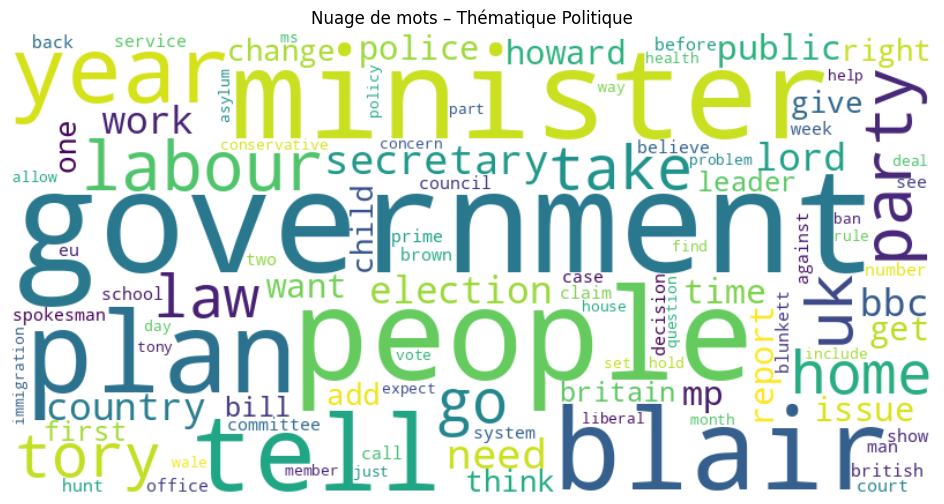

In [13]:
# Vocabulaire pour la thématique "politics"
vocabularies["politics"].head(10)
# Récupérer le vocabulaire politique
politics_vocab = vocabularies["politics"]

# Créer un dictionnaire {mot: fréquence}
politics_freq = dict(zip(politics_vocab["word"], politics_vocab["count"]))

# Générer le nuage de mots
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate_from_frequencies(politics_freq)

# Affichage
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots – Thématique Politique")
plt.show()

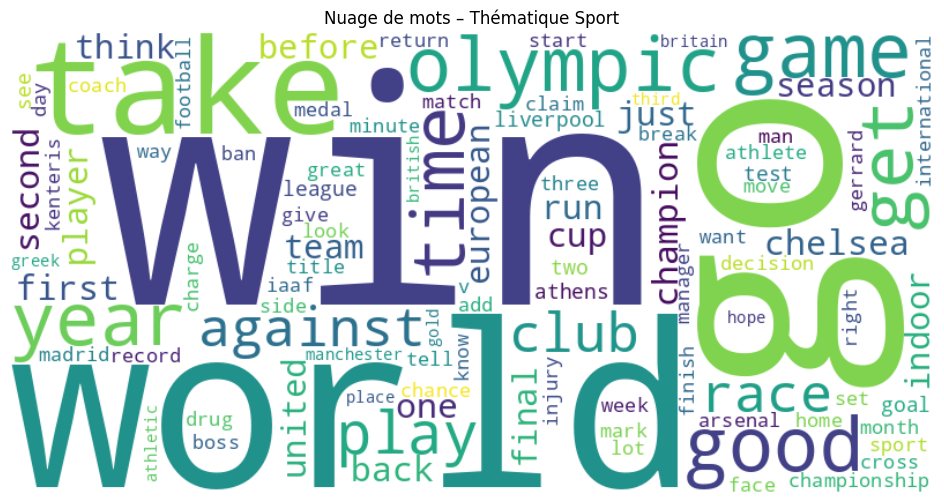

In [14]:
# Vocabulaire pour la thématique "sport"
vocabularies["sport"].head(10)
# Récupérer le vocabulaire sportif
sport_vocab = vocabularies["sport"]

# Créer un dictionnaire {mot: fréquence}
sport_freq = dict(zip(sport_vocab["word"], sport_vocab["count"]))

# Générer le nuage de mots
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate_from_frequencies(sport_freq)

# Affichage
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots – Thématique Sport")
plt.show()

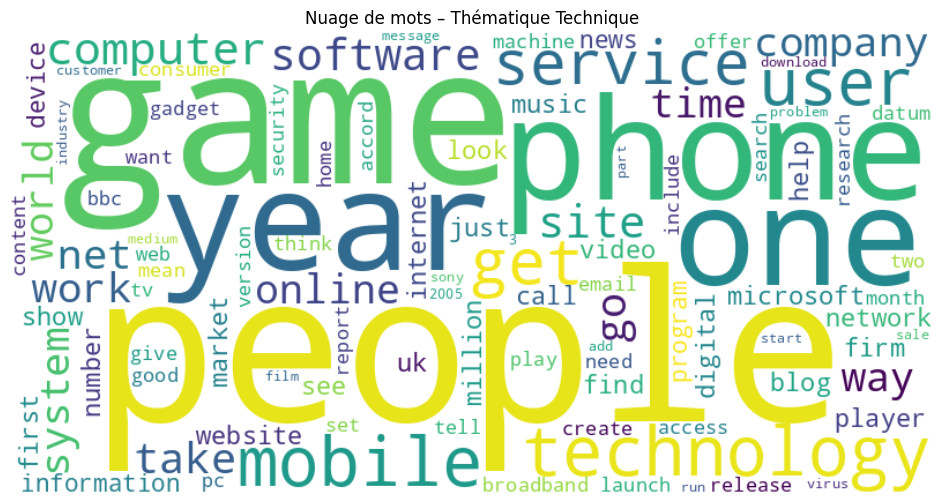

In [15]:
# Vocabulaire pour la thématique "tech"
vocabularies["tech"].head(10)
# Récupérer le vocabulaire technique
tech_vocab = vocabularies["tech"]

# Créer un dictionnaire {mot: fréquence}
tech_freq = dict(zip(tech_vocab["word"], tech_vocab["count"]))

# Générer le nuage de mots
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate_from_frequencies(tech_freq)

# Affichage
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots – Thématique Technique")
plt.show()

### 5. POS-tagging et analyse des dépendances

- Pour cette analyse, nous avons sélectionné 50 documents appartenant à la thématique Sport.
- Ces documents sont utilisés pour appliquer le POS-tagging et l’analyse des dépendances syntaxiques à l’aide de SpaCy.
- Cette étape permet d’identifier la fonction grammaticale des mots ainsi que les relations syntaxiques entre eux, afin de mieux comprendre la structure linguistique des textes de cette thématique.

In [16]:
# Prendre les 50 premiers textes de la classe sport:
texts = df[df['label_encoded'] == 1]['tokens'].head(50)


In [17]:

# POS pertinents pour l'analyse
TARGET_POS = ["NOUN", "VERB", "ADJ", "ADV", "PROPN"]

pos_counter = Counter()
total_tokens = 0

for text in tqdm(texts, desc="POS tagging"):
    doc = nlp_eng(text)
    for token in doc:
        total_tokens += 1
        if token.pos_ in TARGET_POS:
            pos_counter[token.pos_] += 1
            


print("\nDistribution des POS tags :")
for pos, count in pos_counter.items():
    print(f"{pos}: {count} ({count / total_tokens * 100:.2f}%)")




POS tagging: 100%|██████████| 50/50 [00:01<00:00, 45.89it/s]


Distribution des POS tags :
NOUN: 2903 (35.61%)
VERB: 1020 (12.51%)
PROPN: 2518 (30.88%)
ADJ: 989 (12.13%)
ADV: 240 (2.94%)


In [18]:
# Collect examples of words for each POS
pos_examples = defaultdict(set)

for text in texts:
    doc = nlp_eng(text)
    for token in doc:
        if token.pos_ in TARGET_POS:
            if len(pos_examples[token.pos_]) < 10:
                pos_examples[token.pos_].add(token.lemma_.lower())

print("\nExemples de mots par POS :")
for pos, words in pos_examples.items():
    print(f"\n{pos} – exemples :")
    for w in words:
        print(f"  - {w}")


Exemples de mots par POS :

NOUN – exemples :
  - hamstring
  - treatment
  - training
  - force
  - championship
  - champion
  - week
  - holme
  - injury
  - moment

VERB – exemples :
  - walk
  - look
  - reveal
  - disappoint
  - hit
  - pick
  - decide
  - keep
  - run
  - withdraw

PROPN – exemples :
  - grand
  - south
  - hamstring
  - weekend
  - european
  - holmes
  - force
  - kelly
  - africa
  - birmingham

ADJ – exemples :
  - compete
  - intensive
  - fit
  - able
  - olympic
  - athletic
  - cautious
  - indoor
  - good
  - double

ADV – exemples :
  - constantly
  - back
  - currentily
  - sincerely
  - first
  - ago
  - exclusively
  - hardly
  - officially
  - really


In [19]:
pos_freq = {pos: Counter() for pos in TARGET_POS}

for text in texts:
    doc = nlp_eng(text)
    for token in doc:
        if token.pos_ in pos_freq:
            pos_freq[token.pos_][token.lemma_.lower()] += 1

print("\nTop 10 mots par POS :")
for pos, counter in pos_freq.items():
    print(f"\n{pos}:")
    for word, freq in counter.most_common(10):
        print(f"  {word} ({freq})")


Top 10 mots par POS :

NOUN:
  club (39)
  time (38)
  year (33)
  game (30)
  season (29)
  race (29)
  champion (25)
  player (25)
  week (23)
  month (23)

VERB:
  take (44)
  go (33)
  get (30)
  think (30)
  win (25)
  play (22)
  run (20)
  keep (20)
  add (20)
  see (18)

ADJ:
  good (30)
  olympic (22)
  final (22)
  first (20)
  second (18)
  indoor (17)
  right (14)
  great (13)
  former (13)
  international (12)

ADV:
  just (24)
  back (14)
  ahead (10)
  really (8)
  currently (8)
  far (8)
  forward (7)
  desailly (6)
  ago (5)
  first (5)

PROPN:
  liverpool (37)
  chelsea (34)
  parry (27)
  arsenal (27)
  gerrard (26)
  win (25)
  united (22)
  ac (22)
  european (21)
  league (21)


In [20]:
# Définition de la variable
entity_counter = Counter()

# Comptage des entités
TARGET_ENTITIES = ["PERSON", "ORG", "GPE", "DATE"]

for text in texts:
    doc = nlp_eng(text)
    for ent in doc.ents:
        if ent.label_ in TARGET_ENTITIES:
            entity_counter[ent.label_] += 1

# Affichage
print("\nDistribution des entités nommées :")
for ent, count in entity_counter.items():
    print(f"{ent}: {count}")



Distribution des entités nommées :
DATE: 196
GPE: 121
ORG: 114
PERSON: 216


In [21]:
entity_examples = defaultdict(set)

for text in texts:
    doc = nlp_eng(text)
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG", "GPE"]:
            if len(entity_examples[ent.label_]) < 10:
                entity_examples[ent.label_].add(ent.text)

print("\nExemples d'entités nommées :")
for label, ents in entity_examples.items():
    print(f"\n{label} – exemples :")
    print(ents)


Exemples d'entités nommées :

GPE – exemples :
{'liverpool', 'france', 'dublin', 'london', 'stanley park', 'almunia', 'south africa', 'spain', 'madrid', 'britain'}

ORG – exemples :
{'britton', 'liverpool', 'bbc', 'bbc sport pundit', 'fine spanish football federation', 'liverpool stadium', 'spain antiviolence commission', 'reyes', 'bbc sport admit gerrard', 'world cross'}

PERSON – exemples :
{'steven gerrard', 'maria mccambridge', 'gerrard liverpool', 'steve morgan', 'alan hansen', 'jolene byrne', 'rafael benitez', 'striker fernando moriente', 'parry', 'fernando moriente'}


In [22]:
# Top 10 entités les plus fréquentes

entity_freq = {label: Counter() for label in ["PERSON", "ORG", "GPE"]}

for text in texts:
    doc = nlp_eng(text)
    for ent in doc.ents:
        if ent.label_ in entity_freq:
            entity_freq[ent.label_][ent.text] += 1

print("\nTop 10 entités par type :")
for label, counter in entity_freq.items():
    print(f"\nTop {label}:")
    for ent, freq in counter.most_common(5):
        print(f"  {ent} ({freq})")


Top 10 entités par type :

Top PERSON:
  johnson (9)
  steven gerrard (5)
  kenteris (4)
  sarah claxton (3)
  giggs (3)

Top ORG:
  bbc (13)
  liverpool (3)
  champion league (3)
  dutch league (2)
  wrexham (2)

Top GPE:
  britain (17)
  madrid (13)
  liverpool (10)
  russia (8)
  france (7)


#### Analyses des Dépendances 

In [23]:

# Pour stocker les longueurs des phrases
sentence_lengths = []

# Pour compter les types de dépendances
dep_counter = Counter()

for text in tqdm(texts, desc="Dependency analysis"):
    doc = nlp_eng(text)
    for sent in doc.sents:
        sentence_lengths.append(len(sent))  # longueur en tokens
        for token in sent:
            dep_counter[token.dep_] += 1  # type de relation syntaxique

# Longueur moyenne des phrases
avg_sentence_len = sum(sentence_lengths) / len(sentence_lengths)
print(f"\nNombre total de phrases : {len(sentence_lengths)}")
print(f"Longueur moyenne des phrases : {avg_sentence_len:.2f} tokens")

# Affichage des 10 dépendances les plus fréquentes
print("\nTop 10 types de dépendances :")
for dep, count in dep_counter.most_common(10):
    print(f"{dep}: {count}")


Dependency analysis: 100%|██████████| 50/50 [00:01<00:00, 49.02it/s]


Nombre total de phrases : 71
Longueur moyenne des phrases : 114.83 tokens

Top 10 types de dépendances :
compound: 3435
amod: 1026
nsubj: 702
dobj: 535
ccomp: 423
nmod: 400
nummod: 302
advmod: 265
npadvmod: 219
conj: 177


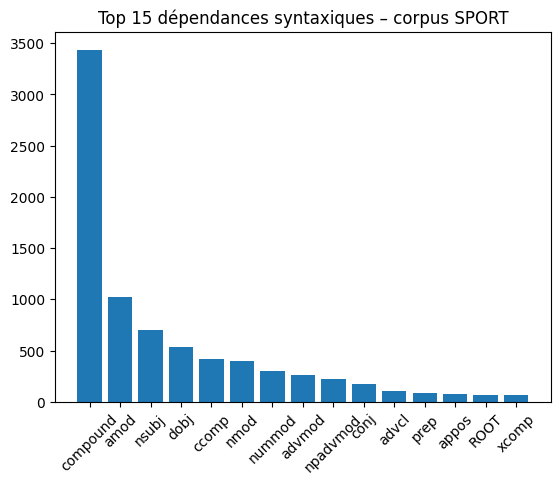

In [24]:

deps, counts = zip(*dep_counter.most_common(15))
plt.bar(deps, counts)
plt.xticks(rotation=45)
plt.title("Top 15 dépendances syntaxiques – corpus SPORT")
plt.show()


### 6. Sauvegarde des données 

In [26]:
# Save the processed DataFrame to a CSV file
df.to_csv("Data/cleaned_data/dataset_with_tokens.csv", index=False)

# Save the texts and their labels to a csv file
df[['text', 'label_encoded']].to_csv("Data/cleaned_data/dataset.csv", index=False)